# Strokes prediction

Objectif : prédire si une personne va subir une attaque 

## 1. Données

#### 1.1. Importation des packages

In [1]:
# packages isuels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set_theme()

# Modélisation
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc # Courbe de ROC et AUC
from sklearn import model_selection


#### 1.2. Importation des données

In [2]:
# importation des données
url = "https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/strokes.csv"
df = pd.read_csv(url, index_col = 0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# information sur le dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


<i> Le dataset importé contient 5110 exemples et 11 variables dont 3 quantitatives ('age', 'avg_glucose_level', 'bmi') et 8 qualitatives.</i> 

#### 1.3. Nettoyage des données

In [4]:
# Taux en % des valeurs manquantes pour chaque variables
n = df.shape[0]
round(df.isna().sum()/n*100, 2)

gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

<i>Seule la variable 'bmi' contient les valeurs manquantes. Le taux est de 3,9%, assez faible pour qu'on fasse une imputation. </i>

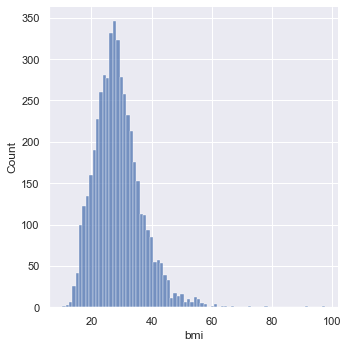

In [5]:
# Distribution de la variable 'bmi'
sns.displot(df["bmi"]);

<i>Ainsi on décide de remplacer les valeurs manquantes de cette variable par sa valeur moyenne vu que sa distribution est plus proche de la distribution normale.</i>

In [6]:
# Imputation
bmi_mean = df["bmi"].mean()
df["bmi"].fillna(bmi_mean, inplace = True)

#### 1.4. Analyse Exploratoire des données

a. Variables quantitatives

In [7]:
# Paramatrès statitisques de position
var_quanti = ['age', 'avg_glucose_level', 'bmi']
round(df[var_quanti].describe(), 1)

,age,avg_glucose_level,bmi
count,5110.0,5110.0,5110.0
mean,43.2,106.1,28.9
std,22.6,45.3,7.7
min,0.1,55.1,10.3
25%,25.0,77.2,23.8
50%,45.0,91.9,28.4
75%,61.0,114.1,32.8
max,82.0,271.7,97.6


<i>On observe que presque la variable âge varie de 0.1 à 82 avec une moyenne de 43.2, <br>
l'indice de masse corporelle varie de 10.3 à 97.6 avec une moyenne de 28.9 et <br>
le niveau moyen de glucose varie de 55.1 à 271.7 avec une moyenne de 106.1</i>

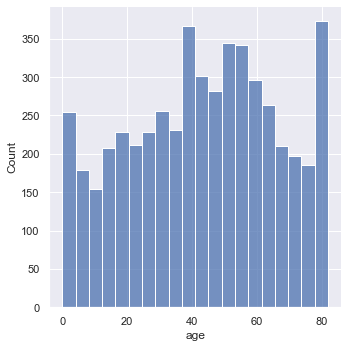

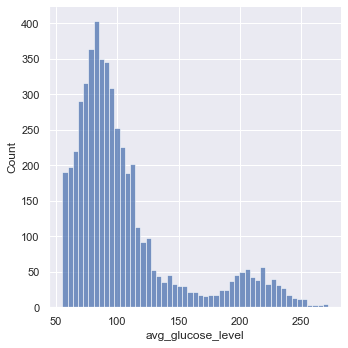

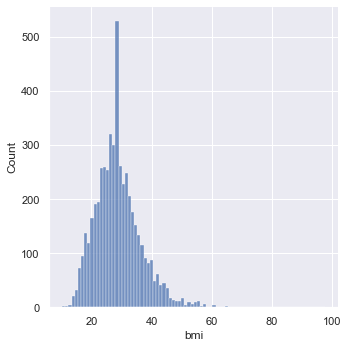

In [8]:
# distribution des variables
for i in var_quanti :
    sns.displot(df[i]);

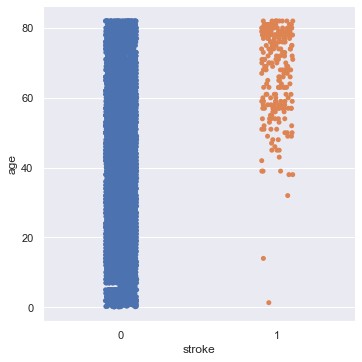

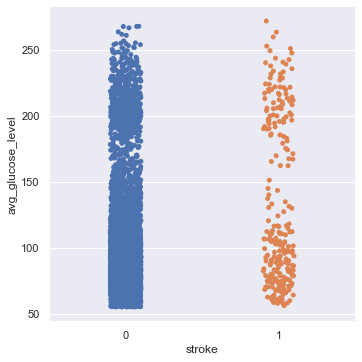

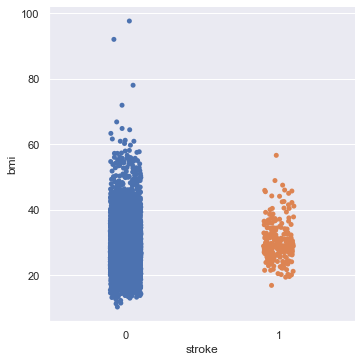

In [9]:
# Analyse bivariée entre les variables quantitatives et la variable 
for i in var_quanti :
    sns.catplot(x = 'stroke', y = i, data = df);


1. <i>La description ci-dessus permet d'observer les individus ayant ayant subis l'attaque sont majoritairement âgés de plus 40 ans, avec quelque exception sur les moins de 40 ans. Ceci montre que l'âge est très déterminant sur la variable cible. <br> </i>

2. <i>Pour l'indice de masse corporelle (bmi), on sait que la valeur normale est entre 18,5 et 25 d'après plusieurs études sur la santé. On constate que les indivudus trop maigre (cad bmi < 18,5) n'ont quasiment pas connu d'attaque. Cependant les individus normaux, ceux qui sont en surpoids (25 < bmi 30) et les obéises sont plus exposés. <br></i>

3. <i>Pour le niveau de glucose, on observe une diminution de nombre d'individus ayant subi l'attaque autour de la valeur normal (120 et 180).</i> <br>

<i>Tous ces constats vont servir plutard à la catégorisation des ces variables quantitatives.</i>

#### Distance de Kolmogorov

In [10]:
def d_ks(v, df):
    test = round(stats.kstest(df[v][df.stroke == 1], df[v][df.stroke == 0])[0], 2)
    return test

In [11]:
import scipy.stats as stats

d_ks_var = []

for i in var_quanti :
    d = d_ks(i, df)
    d_ks_var.append(d)

d_ks_var

[0.54, 0.24, 0.19]

<i>Le résultat ci-dessus nous permet juste d'avoir une idée sur l'intensité de la relation qui existe entre ces variables quantitatives et la variable cible. L'âge (0.26 < d < 0.65) a une intensité moyenne et les autres ont une faible intensité (d < 0.26)</i>

b. Variables qualitatives

In [12]:
# Les modalités de chaque variables
var_quali = ["ever_married", "work_type", "Residence_type", "smoking_status", "hypertension", "heart_disease", "gender"]

for i in var_quali :
    print(df[i].value_counts(), "\n")

Yes    3353
No     1757
Name: ever_married, dtype: int64 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 

0    4612
1     498
Name: hypertension, dtype: int64 

0    4834
1     276
Name: heart_disease, dtype: int64 

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 



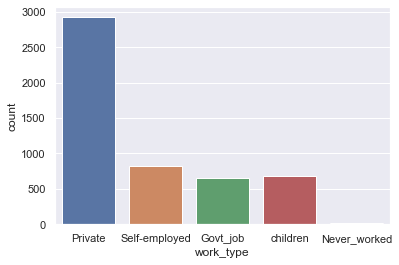

In [13]:
# Fréquence sur la variable 'work_type'
sns.countplot(x = 'work_type', data = df);

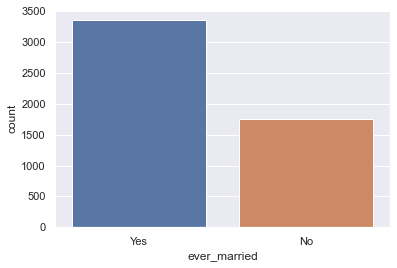

In [14]:
# Fréquence sur la variable 'ever_married'
sns.countplot(x = 'ever_married', data = df);

In [15]:
# Croisement avec la variable cible
# Proportion en % de chaque modalité par rapport à la variable cible

for i in var_quali :
    tab = pd.crosstab(df['stroke'], df[i]).apply(lambda r: r/r.sum(), axis=1)
    print(round(tab*100, 1), "\n")

ever_married    No   Yes
stroke                  
0             35.5  64.5
1             11.6  88.4 

work_type  Govt_job  Never_worked  Private  Self-employed  children
stroke                                                             
0              12.8           0.5     57.1           15.5      14.1
1              13.3           0.0     59.8           26.1       0.8 

Residence_type  Rural  Urban
stroke                      
0                49.4   50.6
1                45.8   54.2 

smoking_status  Unknown  formerly smoked  never smoked  smokes
stroke                                                        
0                  30.8             16.8          37.1    15.4
1                  18.9             28.1          36.1    16.9 

hypertension     0     1
stroke                  
0             91.1   8.9
1             73.5  26.5 

heart_disease     0     1
stroke                   
0              95.3   4.7
1              81.1  18.9 

gender  Female  Male  Other
stroke          

<i>Les croisements ci-dessus montrent comment la proportion d'individus ayant subi l'attaque varie en fonction des modalités.</i>

<i>On constate par exemple que ces individus :</i>

1. <i>Sont des mariés (88,4%)</i>
2. <i>Ont un Type de travail : Private (59,8%)</i>
3. <i>N'ont pas de l'hypertension (73,5%)</i>
4. <i>N'ont jamais eu de maladie cardiaque (81,1%)</i>

<i>Ceci permet d'avoir une idée sur le profil des individus ayant subi une attaque.</i>

c. Variable cile

In [16]:
# Variation cible
df['stroke'] = df['stroke'].astype('category')
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

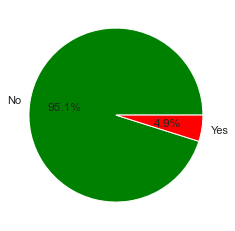

In [17]:
# Proportion des individus ayant subi l'attaque
effectif = df['stroke'].value_counts()
plt.pie(effectif, labels = ['No', 'Yes'], colors = ['green', 'red'], autopct ='%1.1f%%')
plt.show()

<i>On voit que 4.9% d'individus ont subi l'attaque sur le 5110. On est face à une situation des données déséquilibrée. L'équilibrage des données sera faite un peu plus loin. </i>

#### 1.5. Suppression des variables inutiles

<i>Les constats faits au point précedant permet de se passer de certaines variables jugé peu importantes par rapport à leur lien avec la variable cible.
A noté que cette affirmation peut se renforcer (ou être refutée) en calculant le "V de cramer" et "la distance de Kolmogorov" pour chaque variable explicative et la variable cible. Où encore après analyse de colinéarité entre variables explicatives. Cependant, dans le cadre de ce travail, on se permet d'élaguer ces variables juste avec les constats descriptifs.</i>

In [18]:
# On supprime les variables jugées inutiles
df_new = df.drop(['gender', 'smoking_status', 'Residence_type'], axis = 1)
df_new.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,stroke
id,,,,,,,,
9046,67.0,0,1,Yes,Private,228.69,36.600000,1
51676,61.0,0,0,Yes,Self-employed,202.21,28.893237,1
31112,80.0,0,1,Yes,Private,105.92,32.500000,1
60182,49.0,0,0,Yes,Private,171.23,34.400000,1
1665,79.0,1,0,Yes,Self-employed,174.12,24.000000,1


#### 1.6. Optimisation des variables

<i>A cet étape, on transforme toutes les variables quantitatives en qualitatives pour facilité l'implementation et l'interpretation du modèle que l'on veut construire.</i>

In [19]:
# Variable age : Jeune pour moins de 40 ans et adulte pour plus de 40 ans
age_max = df_new["age"].max()
df_new["age"] = pd.cut(x = df_new['age'], bins = [0, 40, age_max], labels = ["jeune", "adulte"])

pd.crosstab(df_new['stroke'], df_new["age"])

age,jeune,adulte
stroke,,
0,2236,2625
1,8,241


In [20]:
# variable bmi : classe 1 moins de 18, classe 2 entre 18 et 25 et classe 3 plus 25
bmi_max = df_new["bmi"].max()
df_new["bmi"] = pd.cut(x = df_new['bmi'], bins = [0, 18, 25, bmi_max], labels = ['trop_mince', 'normale', 'surpoids'])

pd.crosstab(df_new['stroke'], df_new["bmi"])

bmi,trop_mince,normale,surpoids
stroke,,,
0,288,1281,3292
1,1,37,211


In [21]:
# variable avg_glucose_level : (120 et 180) classe 1 moins de 120, classe 2 entre 120 et 25 et classe 3 plus 25
glucose_max = df_new["avg_glucose_level"].max()
df_new["avg_glucose_level"] = pd.cut(x = df_new['avg_glucose_level'], 
                                     bins = [0, 120, 180, glucose_max], 
                                     labels = ['faible', 'normale', 'elevee'])

pd.crosstab(df_new['stroke'], df_new["avg_glucose_level"])

avg_glucose_level,faible,normale,elevee
stroke,,,
0,3844,513,504
1,147,23,79


<i>Pour la variable 'work_type', on se décide de réduire les modalités en mélangeant la classe 'children' avec 'Never_worked' puis on passe par le recodage numérique.</i>

In [22]:
# Définition de la fonction qui va opérer
def my_recode(var):
    if var == "Private":
        return "Private"
    elif var == "Govt_job":
        return "Govt_job"
    elif var == "Self-employed":
        return "Self-employed"
    else:
        return "No_Worked"

df_new["work_type"] = df_new["work_type"].apply(my_recode)


In [23]:
pd.crosstab(df_new['stroke'], df_new["work_type"])

work_type,Govt_job,No_Worked,Private,Self-employed
stroke,,,,
0,624,707,2776,754
1,33,2,149,65


#### 1.8. Dichotomisation des variables

In [24]:
# Dichonomisation
df_new = df_new.join(pd.get_dummies(df_new["age"], prefix = 'age'))
df_new = df_new.join(pd.get_dummies(df_new["hypertension"], prefix = 'hypt'))
df_new = df_new.join(pd.get_dummies(df_new["heart_disease"], prefix = 'heart'))
df_new = df_new.join(pd.get_dummies(df_new["ever_married"], prefix = 'married'))
df_new = df_new.join(pd.get_dummies(df_new["work_type"], prefix = 'work'))
df_new = df_new.join(pd.get_dummies(df_new["avg_glucose_level"], prefix = 'glucos'))
df_new = df_new.join(pd.get_dummies(df_new["bmi"], prefix = 'bmi'))

In [25]:
# Info sur le nouveau dataset
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 5110 non-null   category
 1   hypertension        5110 non-null   int64   
 2   heart_disease       5110 non-null   int64   
 3   ever_married        5110 non-null   object  
 4   work_type           5110 non-null   object  
 5   avg_glucose_level   5110 non-null   category
 6   bmi                 5110 non-null   category
 7   stroke              5110 non-null   category
 8   age_jeune           5110 non-null   uint8   
 9   age_adulte          5110 non-null   uint8   
 10  hypt_0              5110 non-null   uint8   
 11  hypt_1              5110 non-null   uint8   
 12  heart_0             5110 non-null   uint8   
 13  heart_1             5110 non-null   uint8   
 14  married_No          5110 non-null   uint8   
 15  married_Yes         5110 non-null 

## 2. Méthodes

#### 2.1. Echantillonage

In [26]:
# Separtaion des features X et de la variable cible Y
X = df_new.iloc[:, 8:25]
y = df_new["stroke"]

#### 2.2. Séparation de base Train et Test

In [27]:
# Echantillonage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1986) 

#### 2.3. Equilibrage des données : SMOTE

In [28]:
columns = X_train.columns

# On instatncie l'algorithme avec les paramètres par défauts
oversample = SMOTE()
X_SMOTEd, y_SMOTEd = oversample.fit_resample(X_train, y_train)

X_SMOTEd = pd.DataFrame(data = X_SMOTEd, columns = columns)
y_SMOTEd = pd.DataFrame(data = y_SMOTEd, columns = ['stroke'])

In [29]:
# Vérification de la proportion actuelle
print(y_SMOTEd.stroke.value_counts()/len(y_SMOTEd))

0    0.5
1    0.5
Name: stroke, dtype: float64


#### 2.4. Entrainement du modèle : Regression Logistique

<i>Le modèle sera entrainé avec les meilleurs pramètres que va renvoyer la fonction 'GridSearchCV'. On choisit le paramètre 'accuracy' comme le facteur principal du reglage.</i>

In [30]:
# Définition des paramètres à regler
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
              {'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

# Entrainment du modèle
model_log = LogisticRegression()

model_log_GS = GridSearchCV(estimator = model_log,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           verbose = 0)

model_log_GS.fit(X_SMOTEd, y_SMOTEd)


C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\sokin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Use

C:\Users\sokin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='accuracy')

In [31]:
# Affichage du paramètre optimals
print(model_log_GS.best_estimator_.get_params())

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [34]:
# Entrainement du modèle avec les paramètres ci-dessus
model_Final = LogisticRegression(C = 0.01, 
                                 fit_intercept = True, 
                                 intercept_scaling = 1, 
                                 max_iter = 100, 
                                 penalty = 'l2', 
                                 solver = 'lbfgs',
                                 tol = 0.0001)

model_Final.fit(X_SMOTEd.values, y_SMOTEd.values)

C:\Users\sokin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=0.01)

#### 2.5. Validation du modèle

In [35]:
# Évaluation du modèle de classification
y_pred = model_Final.predict(X_test)

In [36]:
# Matrice de confusion
cm = pd.crosstab(y_test, y_pred, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,1142,324
1,33,34


In [38]:
# taux de bonnes prédictions du modèle.
model_Final.score(X_test, y_test)

0.7671232876712328

In [39]:
# Valeur AUC
probs = model_Final.predict_proba(X_test)
y_preds = np.where(probs[:, 1] > 0.5, 1, 0)
fpr, tpr, seuils = roc_curve(y_test, probs[:, 1], pos_label = 1)
roc_auc = auc(fpr, tpr)
roc_auc

0.7477041803261997

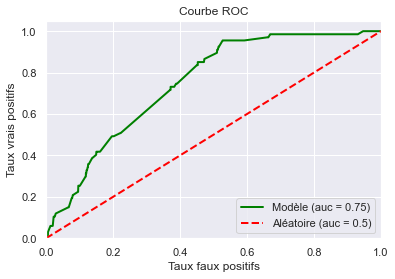

In [40]:
# courbe de ROC
plt.plot(fpr, tpr, color = 'green', lw = 2, label = 'Modèle (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--', label = 'Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc = "lower right")
plt.show();

<i>Avec un AUC = 0.75, c'est déjà bon pour un modèle. On suppose qu'un autre reglage des paramètres où création des autres variables explicatives pourront améliorer AUC. </i>

#### 2.6. Variables Importantes du modèle

<i>On peut visualiser l'importance des variables dans le modèle avec les codes ci-dessous. Ceci permet d'interpreter le résultat de l'entrainement.</i>

In [41]:
# Coefficient du modèle
Coef_model = model_Final.coef_[0]

var_model = X.columns.to_list()
var_impor = pd.DataFrame(var_model, columns = ['Features'])
var_impor['Importance'] = pow(math.e, Coef_model)
var_impor = var_impor.sort_values(by = ['Importance'], ascending = True)

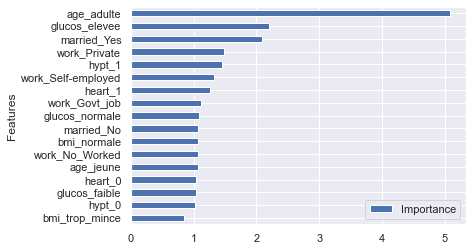

In [42]:
# Le top 10
var_impor.plot.barh(x = "Features", y = "Importance")
plt.show()

<i>On peut observer que l'age_adulte est un grand facteur pour subir des attaques, suivi du niveau élévé de glucose et du fait d'être marié. </i>

#### 2.7. Autre méthode : k plus proches voisins

Il est nécessaire de comparer son modèle avec un ou plusieurs autres modèles pour juger sa perfomance et/ou choisir la meilleur qui s'adapte mieux aux données. On choisi d'entrainer un modèle de 'K plus proches voisins'. 

In [43]:
# Entrainement du modèle
model_kv = neighbors.KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
model_kv.fit(X_SMOTEd, y_SMOTEd)

C:\Users\sokin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [44]:
# Prédiction
y_pred_kv = model_kv.predict(X_test)
pd.crosstab(y_test, y_pred_kv, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,1214,252
1,47,20


In [45]:
# Calcul du score
#Score du modèle utilisant la distance de Minkowski
model_kv.score(X_test, y_test)

0.8049575994781474

#### 2.5. Comparaison des modèles

<p><i>Sans pour atant chercher à aller loin dans le travail, on peut conclure que la regression logistique obetenu ci-haut avec  les paramètres réglés est moins performant que le K plus proche voisin compte tenu de la différence du score obtenu pour chaque modèle.</i></p>

<p><i>A noter qu'un autre réglage des paramètres plus approfondi pour chaque modèle peut changer ladonne, mais pour le cadre de ce travail, on se contente de se limiter là.</i></p>


Fin du travail